In [71]:
import numpy as np
import math

# Calculate c(z) for n=0 to 5
def c_stumpff(z):
    n=0
    while z > 0.1:
        z/=4
        n+=1
    c4 = 1/math.factorial(4) - z/math.factorial(6)
    c5 = 1/math.factorial(5) - z/math.factorial(7)
    z_bar = -z
    p = z_bar
    k = 8
    not_converged = True
    while not_converged:
        c4_prv = c4
        p = p*z_bar
        c4 = c4 + p/math.factorial(k)
        k += 1
        c5 = c5 + p/math.factorial(k)
        k += 1
        if c4 == c4_prv:
            not_converged = False
    c3 = 1/6 - z*c5
    c2 = 1/2 - z*c4
    c1 = 1 - z*c3
    while n > 0:
        z = 4.*z
        c5 = 0.0625*(c5+c4+c3*c2) # in paper pseudocode c3 and c2 are added
        c4 = 0.125*c3*(1+c1) # in paper pseudocode these are subtracted
        c3 = 1./6.-z*c5
        c2 = 0.5-z*c4
        c1 = 1.-z*c3 
        n -= 1
    c0 = 1. - z*c2
    return c0,c1,c2,c3,c4,c5

def cartesianToJacobi(r,m):
    R = m[0]*r[0]
    r_prime = np.zeros((len(r),3))
    for i in range(1,len(m)):
        r_prime[i] = r[i] - R/np.sum(m[:i])
        R = R*(1+m[i]/np.sum(m[:i])) + m[i]*r_prime[i]
    r_prime[0] = R / np.sum(m[:len(m)-1])
    return r_prime

def jacobiToCartesian(r_prime,m):
    R = r_prime[0]*np.sum(m[:len(m)-1])
    r = np.zeros((len(r_prime),3))
    for i in range(len(m)-1,0,-1):
        R = (R-m[i]*r_prime[i])/np.sum(m[:i+1])
        r[i] = r_prime[i] + R
        R = R*np.sum(m[:i])
    r[0] = R/m[0]
    return r

def G(beta,X,n):
    return X**n*c_stumpff(beta*X**2)[n]

# returns position and velocity of a single mass after a time dt
def newtonKepler(X_0,r_0,v_0,m,dt):
    M = np.max(m)
    beta = 2*M/np.linalg.norm(r_0) - np.linalg.norm(v_0)**2
    eta_0 = np.dot(r_0,v_0)
    zeta_0 = M - beta*np.linalg.norm(r_0)
    X = X_0
    X_prev1 = X_0 + 1.
    precision = 1e-10
    # while (X_prev1 != X) or (X_prev2 != X):
    while np.abs(X_prev1 - X) > precision:
        X_prev2 = X_prev1
        X_prev1 = X
        X = (X*(eta_0*G(beta,X,1) + zeta_0*G(beta,X,2)) - eta_0*G(beta,X,2) - zeta_0*G(beta,X,3) + dt)/(np.linalg.norm(r_0) + eta_0*G(beta,X,1) + zeta_0*G(beta,X,2))
        # print("x_prev1",X_prev1)
        # print("x_prev2",X_prev2)
        # print("x",X)
    f = 1 - (M*G(beta,X,2))/np.linalg.norm(r_0)
    g = dt - M*G(beta,X,3)
    r = np.linalg.norm(r_0) + eta_0*G(beta,X,1) + zeta_0*G(beta,X,2)
    f_dot = -M*G(beta,X,1)/(r*np.linalg.norm(r_0))
    g_dot = 1 - M*G(beta,X,2)/r
    return f*r_0 + g*v_0,f_dot*r_0 + g_dot*v_0

# calculate perturbing accelerations
def delta_v_cartesian(r,m,dt):
    a = np.zeros((len(r),3))
    for i in range(len(r)):
        for j in range(1,len(r)):
            if j != i:
                r_ij = r[j] - r[i]
                r_0j = r[j] - r[0]
                a[i] = -m[i]*(r_ij/np.linalg.norm(r_ij)**3 - r_0j/np.linalg.norm(r_0j)**3)
    return a*dt

# Test
masses = np.array([1.0,1e-3,1e-3])
r_0 = np.array([[0.,0.,0.],[1.,0.,0.],[1.800999000999001,0.,0.]])
v_0 = np.array([[0.,0.,0.],[0.,1.0,0.],[0,0.7835163064519433,0.]])

dt=1e-3
time = np.arange(0,500*np.pi,dt)
r_0_jacob = np.zeros((len(time),len(masses),3))
v_0_jacob = np.zeros((len(time),len(masses),3))

# start in jacobi coords for drift 
r_0_jacob[0] = cartesianToJacobi(r_0,masses)
v_0_jacob[0] = cartesianToJacobi(v_0,masses)
for t in range(1,len(time)):
    if t % 1000 == 0:
        print(f"time {t}/{len(time)}")
    # Drift
    for j in range(1,len(masses)):
        r_0_jacob[t,j], v_0_jacob[t,j] = newtonKepler(0.1,r_0_jacob[t-1,j],v_0_jacob[t-1,j],masses,dt/2)

    # Kick  
    v_0_jacob[t] += cartesianToJacobi(delta_v_cartesian(jacobiToCartesian(r_0_jacob[t],masses),masses,dt),masses)
    
    # Drift
    for j in range(1,len(masses)):
        r_0_jacob[t,j], v_0_jacob[t,j] = newtonKepler(0.1,r_0_jacob[t,j],v_0_jacob[t,j],masses,dt/2)
    
cartesian = np.array([jacobiToCartesian(r_0_jacob[i],masses) for i in range(len(time))])



time 1000/1570797
time 2000/1570797
time 3000/1570797
time 4000/1570797
time 5000/1570797
time 6000/1570797
time 7000/1570797
time 8000/1570797
time 9000/1570797
time 10000/1570797
time 11000/1570797
time 12000/1570797
time 13000/1570797
time 14000/1570797
time 15000/1570797
time 16000/1570797
time 17000/1570797
time 18000/1570797
time 19000/1570797
time 20000/1570797
time 21000/1570797
time 22000/1570797
time 23000/1570797
time 24000/1570797
time 25000/1570797
time 26000/1570797
time 27000/1570797
time 28000/1570797
time 29000/1570797
time 30000/1570797
time 31000/1570797
time 32000/1570797
time 33000/1570797
time 34000/1570797
time 35000/1570797
time 36000/1570797
time 37000/1570797
time 38000/1570797
time 39000/1570797
time 40000/1570797
time 41000/1570797
time 42000/1570797
time 43000/1570797
time 44000/1570797
time 45000/1570797
time 46000/1570797
time 47000/1570797
time 48000/1570797
time 49000/1570797
time 50000/1570797
time 51000/1570797
time 52000/1570797
time 53000/1570797
ti

KeyboardInterrupt: 

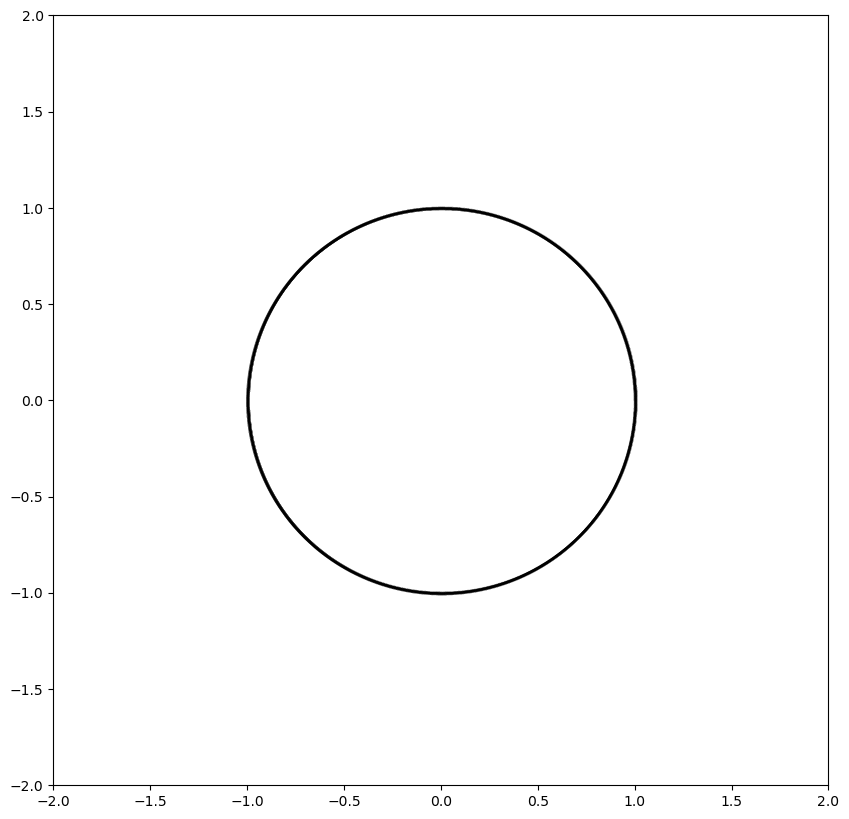

In [69]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
plt.xlim(-2,2)
plt.ylim(-2,2)
#plt.scatter(cartesian[:,0,0],cartesian[:,0,1],s=0.01)
n = 1
plt.scatter(cartesian[::n,1,0],cartesian[::n,1,1],s=0.001,color='k',marker=".")
#plt.scatter(cartesian[:,2,0],cartesian[:,2,1],s=0.01)
plt.show()